## Initialization

In [1]:
from tensorflow.keras.layers import Dense, Conv2D, Flatten, AveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
import numpy as np
from tensorflow.keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [8]:
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)


Found 7591 validated image filenames.


In [5]:
imgs, label = next(train_gen_flow)

## EDA

In [9]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


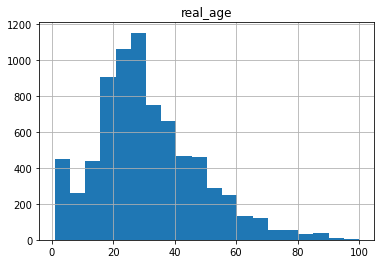

In [10]:
hist = labels.hist(bins=20)

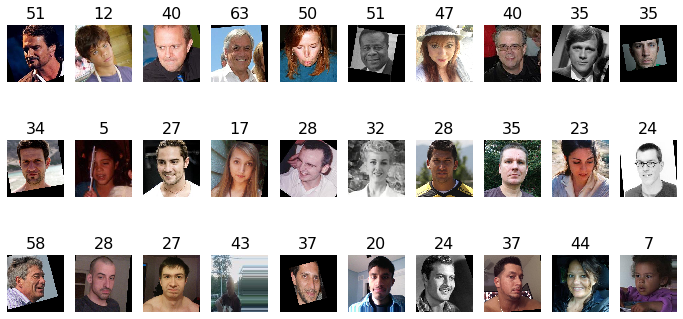

In [11]:
def plots(ims, figsize=(12,6), rows=3, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(rows*cols):
        
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

plots(imgs, titles=label)

### Findings

1. People of older age are less represented in the dataset.
2. Dataset consists of pictures of people of different quality, face angle, race, gender, and circumstances.

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [ ]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [13]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    # place your code here
    

    train_gen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory='/datasets/faces/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='training',
        
            seed=12345)

    return train_gen_flow

In [14]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    # place your code here
    test_gen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory='/datasets/faces/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='validation',
            seed=12345)    

    return test_gen_flow

In [15]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    # place your code here
    backbone = ResNet50(
    input_shape=input_shape, weights='imagenet', include_top=False
    )
 
    # freeze ResNet50 with the top removed
    #backbone.trainable = True #We don't freeze the backbone, it's trainable by default
 
    model = Sequential()
    model.add(backbone) #adding the backbone
    model.add(GlobalAveragePooling2D())
    #Like average pooling
    model.add(Dense(units=120, activation='relu'))

    model.add(Dense(units=84, activation='relu'))  
    model.add(Dense(units=48, activation='relu'))
    model.add(Dense(1, activation='relu')) #The  fully connected layer responsible for classification
 
    optimizer = Adam(lr = 0.0001)
 
    model.compile(
        optimizer = optimizer,
        loss='mse',
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )    

    return model

In [16]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    # place your code here
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
 
    if validation_steps is None:
        validation_steps = len(test_data) 
 
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True,
    )    

    return model

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [ ]:
# prepare a script to run on the GPU platform

#all the imports in python file was done before the functions definition

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
    
    labels = pd.read_csv('/datasets/faces/labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.25,horizontal_flip=True,vertical_flip=True)

        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

Found 5694 validated image filenames.

Found 1897 validated image filenames.

2022-07-28 11:15:04.553861: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1

2022-07-28 11:15:05.230221: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0

coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s

2022-07-28 11:15:05.230311: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

2022-07-28 11:15:05.230345: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2022-07-28 11:15:05.319903: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10

2022-07-28 11:15:05.334630: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10

2022-07-28 11:15:05.657603: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10

2022-07-28 11:15:05.694652: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10

2022-07-28 11:15:05.694790: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

2022-07-28 11:15:05.699309: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-07-28 11:15:05.699691: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA

2022-07-28 11:15:05.748862: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2022-07-28 11:15:05.752130: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x46b6a20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:

2022-07-28 11:15:05.752165: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version

2022-07-28 11:15:05.987576: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x473ca40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:

2022-07-28 11:15:05.987616: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0

2022-07-28 11:15:05.989986: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0

coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-07-28 11:15:05.990040: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

2022-07-28 11:15:05.990049: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2022-07-28 11:15:05.990074: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10

2022-07-28 11:15:05.990083: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10

2022-07-28 11:15:05.990091: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10

2022-07-28 11:15:05.990100: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10

2022-07-28 11:15:05.990107: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

2022-07-28 11:15:05.994539: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-07-28 11:15:05.996430: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

2022-07-28 11:15:09.370109: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:

2022-07-28 11:15:09.370162: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 

2022-07-28 11:15:09.370171: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 

2022-07-28 11:15:09.377225: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 178 steps, validate for 60 steps

Epoch 1/20

2022-07-28 11:15:33.939987: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2022-07-28 11:15:36.196124: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

178/178 - 70s - loss: 288.8914 - mean_absolute_error: 12.3274 - val_loss: 470.8213 - val_mean_absolute_error: 16.5966

Epoch 2/20

178/178 - 38s - loss: 103.4277 - mean_absolute_error: 7.6874 - val_loss: 466.7423 - val_mean_absolute_error: 16.4045

Epoch 3/20

178/178 - 38s - loss: 77.0778 - mean_absolute_error: 6.6198 - val_loss: 227.2982 - val_mean_absolute_error: 11.9343

Epoch 4/20

178/178 - 38s - loss: 58.2947 - mean_absolute_error: 5.7916 - val_loss: 143.1392 - val_mean_absolute_error: 9.2178

Epoch 5/20

178/178 - 38s - loss: 50.4977 - mean_absolute_error: 5.4101 - val_loss: 132.7420 - val_mean_absolute_error: 9.1135

Epoch 6/20

178/178 - 38s - loss: 39.7550 - mean_absolute_error: 4.7331 - val_loss: 87.6904 - val_mean_absolute_error: 6.9025

Epoch 7/20

178/178 - 37s - loss: 34.5382 - mean_absolute_error: 4.4647 - val_loss: 77.6448 - val_mean_absolute_error: 6.7140

Epoch 8/20

178/178 - 37s - loss: 28.9283 - mean_absolute_error: 4.0943 - val_loss: 78.6605 - val_mean_absolute_error: 6.7006

Epoch 9/20

178/178 - 38s - loss: 23.9385 - mean_absolute_error: 3.7242 - val_loss: 92.0836 - val_mean_absolute_error: 7.0241

Epoch 10/20

178/178 - 37s - loss: 22.7640 - mean_absolute_error: 3.5804 - val_loss: 73.8437 - val_mean_absolute_error: 6.3859

Epoch 11/20

178/178 - 38s - loss: 19.2671 - mean_absolute_error: 3.2988 - val_loss: 78.8356 - val_mean_absolute_error: 6.7750

Epoch 12/20

178/178 - 38s - loss: 17.4801 - mean_absolute_error: 3.1538 - val_loss: 79.8167 - val_mean_absolute_error: 6.6807

Epoch 13/20

178/178 - 37s - loss: 15.4544 - mean_absolute_error: 2.9393 - val_loss: 75.6831 - val_mean_absolute_error: 6.4173

Epoch 14/20

178/178 - 37s - loss: 13.7004 - mean_absolute_error: 2.7753 - val_loss: 79.3933 - val_mean_absolute_error: 6.8958

Epoch 15/20

178/178 - 37s - loss: 13.5044 - mean_absolute_error: 2.7671 - val_loss: 76.1746 - val_mean_absolute_error: 6.7390

Epoch 16/20

178/178 - 37s - loss: 11.8025 - mean_absolute_error: 2.6122 - val_loss: 74.1833 - val_mean_absolute_error: 6.3625

Epoch 17/20

178/178 - 37s - loss: 11.7574 - mean_absolute_error: 2.5784 - val_loss: 68.0141 - val_mean_absolute_error: 6.2165

Epoch 18/20

178/178 - 38s - loss: 12.0730 - mean_absolute_error: 2.5958 - val_loss: 75.0443 - val_mean_absolute_error: 6.4250

Epoch 19/20

178/178 - 37s - loss: 11.0615 - mean_absolute_error: 2.5146 - val_loss: 69.6336 - val_mean_absolute_error: 6.2124

Epoch 20/20

178/178 - 37s - loss: 11.5214 - mean_absolute_error: 2.5529 - val_loss: 70.9938 - val_mean_absolute_error: 6.2711


60/60 - 9s - loss: 72.4773 - mean_absolute_error: 6.3717

Test MAE: 6.3717



## Conclusions

We managed to build the model with a mean absolute error of less than 7, which can be considered a  good result.

Nevertheless, considering the purpose of the model, it is advisable to have customers scan their IDs for alcohol purchases.